In [37]:
import pandas as pd
import konlpy
from konlpy.tag import Komoran
from konlpy.tag import Okt
from pprint import pprint
from collections import defaultdict
from collections import Counter
import warnings # 경고 알림 제거
print(konlpy.__version__)
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook # progress bar
#from konlpy.tag import Mecab #Mecab, Okt 등 형태소 분석기 불러오기,앞에서 코모란불러옴 
import numpy as np
import string # 특수문자
from gensim import corpora
from gensim import models
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning) # 경고 알림이 뜨면 모두 무시

0.6.0


In [38]:
okt=Okt()

In [39]:
data = pd.read_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/naverpay_review_scroll120.csv')

In [40]:
data.head(5)

,날짜,리뷰,별점,month
0,2023년 10월 1일,업데이트 이후로 크기가 큰 4x1 위젯에서 페이 포인트/페이 머니의 금액이 표시가 ...,1,2023년
1,2023년 9월 26일,"특히 삼성페이 연결된 이후 편하게 잘쓰고 있습니다만, 네이버 하나통장 개설 후 주계...",5,2023년
2,2023년 8월 13일,"삼성페이 현장결제 이용 시 데이터, 와이파이 문제 없는데 자꾸 재등록버튼만 나옵니다...",2,2023년
3,2023년 9월 7일,언제나 편하게 잘 쓰고 있습니다. 다만 이번 업데이트 되면서 플립5 커버 화면 사용...,5,2023년
4,2023년 10월 10일,이번 업뎃 후에 문제 발생. 카드가 4개 등록돼 있어서 결제때마다 필요한 다른 카드...,5,2023년


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263 entries, 0 to 1262
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   날짜      1263 non-null   object
 1   리뷰      1263 non-null   object
 2   별점      1263 non-null   int64 
 3   month   1263 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.6+ KB


In [42]:
# 결측치 확인
data.isnull().sum()

날짜       0
리뷰       0
별점       0
month    0
dtype: int64

In [43]:
# 전처리 함수

import re 

def clean_text(text):    
    
    pattern='(\[a-zA-Z0-9\_.+-\]+@\[a-zA-Z0-9]+.\[a-zA-Z0-9-.\]+)' # email제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    text = text.upper()
    
    pattern = '([ㄱ-ㅎㅏ-ㅣ])+' # 한글 자음, 모음 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern=re.compile(r'([^\w]?\d+\.?\,?\)?\d*)+') # 숫자 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern='<[^>]*>' # html 태그 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern='[\r|\n]' # \r,\n 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern= '[^\w\s]' # 특수기호 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)
    
    pattern=re.compile(r'\s+')  #  이중 space 제거
    text=re.sub(pattern=pattern,repl=' ',string=text)

#     hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글과 띄어쓰기를 제외한 모든 글자
#     text=re.sub(pattern=hangul,repl=' ',string=text) # 한글과 띄어쓰기를 제외한 모든 부분을 제거
    
    text=text.strip()
    return text

In [44]:
data['리뷰1'] = data['리뷰'].apply(clean_text)

In [45]:
data.head(5)

,날짜,리뷰,별점,month,리뷰1
0,2023년 10월 1일,업데이트 이후로 크기가 큰 4x1 위젯에서 페이 포인트/페이 머니의 금액이 표시가 ...,1,2023년,업데이트 이후로 크기가 큰 X 위젯에서 페이 포인트 페이 머니의 금액이 표시가 안되...
1,2023년 9월 26일,"특히 삼성페이 연결된 이후 편하게 잘쓰고 있습니다만, 네이버 하나통장 개설 후 주계...",5,2023년,특히 삼성페이 연결된 이후 편하게 잘쓰고 있습니다만 네이버 하나통장 개설 후 주계좌...
2,2023년 8월 13일,"삼성페이 현장결제 이용 시 데이터, 와이파이 문제 없는데 자꾸 재등록버튼만 나옵니다...",2,2023년,삼성페이 현장결제 이용 시 데이터 와이파이 문제 없는데 자꾸 재등록버튼만 나옵니다 ...
3,2023년 9월 7일,언제나 편하게 잘 쓰고 있습니다. 다만 이번 업데이트 되면서 플립5 커버 화면 사용...,5,2023년,언제나 편하게 잘 쓰고 있습니다 다만 이번 업데이트 되면서 플립 커버 화면 사용이 ...
4,2023년 10월 10일,이번 업뎃 후에 문제 발생. 카드가 4개 등록돼 있어서 결제때마다 필요한 다른 카드...,5,2023년,이번 업뎃 후에 문제 발생 카드가 개 등록돼 있어서 결제때마다 필요한 다른 카드로 ...


In [46]:
#불용어 생성

SW = ['카카오','페이','카카오페이','사용','카카오톡','토스','네이버','카톡','이용','가요','때문','하나','무슨','다시','어쩌',
      '해도','무슨','일시','혹시','기능','이제','하라','다른','경우','갑자기','보기','지금','이해','정말','진짜','그냥','예전',
      '아예','안나','자꾸','몇번','한번','자체','건가','워치','뱅크','은행','확인','어가','해주','어요','어서','려고','이유','도대체','아무',
      '하니','다가','계속','면서','가능','주시','려니','라면','자산','삭제','잔액','추가','까지','하나요','어디','먼저','지도','시도','더니',
      '삼성페이']


In [47]:
import pickle

In [48]:
##사용자 사전 추가하기

from ckonlpy.tag import Twitter
twitter = Twitter()

c:\Users\junbong heo\AppData\Local\Programs\Python\Python311\Lib\site-packages\konlpy\tag\_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [49]:
twitter.add_dictionary('주민등록증', 'Noun')
twitter.add_dictionary('결제오류', 'Noun')
twitter.add_dictionary('카드결제', 'Noun')
twitter.add_dictionary('설치 오류', 'Noun')
twitter.add_dictionary('본인인증', 'Noun')
twitter.add_dictionary('연결상태', 'Noun')
twitter.add_dictionary('휴대폰인증', 'Noun')
twitter.add_dictionary('주식창', 'Noun')
twitter.add_dictionary('주민등록번호', 'Noun')
twitter.add_dictionary('인증번호', 'Noun')
twitter.add_dictionary('계좌연결','Noun')
twitter.add_dictionary('계좌번호','Noun')
twitter.add_dictionary('소리 알림','Noun')
twitter.add_dictionary('주식 알림','Noun')
twitter.add_dictionary('업데이트 이후','Noun')
twitter.add_dictionary('삼성페이','Noun')
twitter.add_dictionary('금액표시','Noun')
twitter.add_dictionary('재설치','Noun')
twitter.add_dictionary('적립포인트','Noun')
twitter.add_dictionary('현장결제','Noun')
twitter.add_dictionary('업뎃 후에','Noun')
twitter.add_dictionary('어플 설치','Noun')
twitter.add_dictionary('카드번호','Noun')
twitter.add_dictionary('주민번호','Noun')


In [50]:
def read_documents(input_file_name):
    """문서들을 주어진 이름의 파일로부터 읽어들여 돌려준다."""
    corpus = []
    with open(input_file_name, 'rb') as f:
        temp_corpus = pickle.load(f)
    for page in temp_corpus:
        corpus += page
    return corpus

def text_tokenizing(corpus, tokenizer):
    token_corpus = []

    if tokenizer == "noun":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = twitter.nouns(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)

    elif tokenizer == "morph":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = twitter.nouns(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)

    elif tokenizer == "word":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = corpus[n].split()
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)

        
    return token_corpus

In [51]:
import ipywidgets

In [52]:
data

,날짜,리뷰,별점,month,리뷰1
0,2023년 10월 1일,업데이트 이후로 크기가 큰 4x1 위젯에서 페이 포인트/페이 머니의 금액이 표시가 ...,1,2023년,업데이트 이후로 크기가 큰 X 위젯에서 페이 포인트 페이 머니의 금액이 표시가 안되...
1,2023년 9월 26일,"특히 삼성페이 연결된 이후 편하게 잘쓰고 있습니다만, 네이버 하나통장 개설 후 주계...",5,2023년,특히 삼성페이 연결된 이후 편하게 잘쓰고 있습니다만 네이버 하나통장 개설 후 주계좌...
2,2023년 8월 13일,"삼성페이 현장결제 이용 시 데이터, 와이파이 문제 없는데 자꾸 재등록버튼만 나옵니다...",2,2023년,삼성페이 현장결제 이용 시 데이터 와이파이 문제 없는데 자꾸 재등록버튼만 나옵니다 ...
3,2023년 9월 7일,언제나 편하게 잘 쓰고 있습니다. 다만 이번 업데이트 되면서 플립5 커버 화면 사용...,5,2023년,언제나 편하게 잘 쓰고 있습니다 다만 이번 업데이트 되면서 플립 커버 화면 사용이 ...
4,2023년 10월 10일,이번 업뎃 후에 문제 발생. 카드가 4개 등록돼 있어서 결제때마다 필요한 다른 카드...,5,2023년,이번 업뎃 후에 문제 발생 카드가 개 등록돼 있어서 결제때마다 필요한 다른 카드로 ...
...,...,...,...,...,...
1258,2021년 12월 30일,별로,1,2021년,별로
1259,2022년 6월 14일,별로,1,2022년,별로
1260,2023년 6월 13일,The 89 bvur ccno,5,2023년,THE BVUR CCNO
1261,2021년 8월 10일,아몬더넥레블,5,2021년,아몬더넥레블


In [53]:
data['리뷰2'] = text_tokenizing(data['리뷰1'], tokenizer="noun")

Preprocessing:   0%|          | 0/1263 [00:00<?, ?it/s]

In [54]:
data.head(5)

,날짜,리뷰,별점,month,리뷰1,리뷰2
0,2023년 10월 1일,업데이트 이후로 크기가 큰 4x1 위젯에서 페이 포인트/페이 머니의 금액이 표시가 ...,1,2023년,업데이트 이후로 크기가 큰 X 위젯에서 페이 포인트 페이 머니의 금액이 표시가 안되...,"[업데이트, 이후, 크기, 위젯, 포인트, 금액, 표시, 금융, 비교, 편이, 측면..."
1,2023년 9월 26일,"특히 삼성페이 연결된 이후 편하게 잘쓰고 있습니다만, 네이버 하나통장 개설 후 주계...",5,2023년,특히 삼성페이 연결된 이후 편하게 잘쓰고 있습니다만 네이버 하나통장 개설 후 주계좌...,"[연결, 이후, 다만, 통장, 개설, 계좌, 입금, 이나, 출금, 알림, 불편, 인..."
2,2023년 8월 13일,"삼성페이 현장결제 이용 시 데이터, 와이파이 문제 없는데 자꾸 재등록버튼만 나옵니다...",2,2023년,삼성페이 현장결제 이용 시 데이터 와이파이 문제 없는데 자꾸 재등록버튼만 나옵니다 ...,"[현장결제, 데이터, 와이파이, 문제, 등록, 버튼, 별로, 새로고침, 등록, 버튼..."
3,2023년 9월 7일,언제나 편하게 잘 쓰고 있습니다. 다만 이번 업데이트 되면서 플립5 커버 화면 사용...,5,2023년,언제나 편하게 잘 쓰고 있습니다 다만 이번 업데이트 되면서 플립 커버 화면 사용이 ...,"[언제, 다만, 이번, 업데이트, 플립, 커버, 화면, 불편, 업데이트, 커버, 화..."
4,2023년 10월 10일,이번 업뎃 후에 문제 발생. 카드가 4개 등록돼 있어서 결제때마다 필요한 다른 카드...,5,2023년,이번 업뎃 후에 문제 발생 카드가 개 등록돼 있어서 결제때마다 필요한 다른 카드로 ...,"[이번, 업뎃, 문제, 발생, 카드, 등록, 제때, 마다, 필요, 카드, 선택, 결..."


In [55]:
# 명사 추출 후 해당 단어가 있는지 확인

[x for x in data['리뷰2'] if '토스' in x]

[]

In [56]:
data.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/naver_datafile/naver_preprocessing.csv', index=None, encoding='utf-8')

In [57]:
data.head(5)

,날짜,리뷰,별점,month,리뷰1,리뷰2
0,2023년 10월 1일,업데이트 이후로 크기가 큰 4x1 위젯에서 페이 포인트/페이 머니의 금액이 표시가 ...,1,2023년,업데이트 이후로 크기가 큰 X 위젯에서 페이 포인트 페이 머니의 금액이 표시가 안되...,"[업데이트, 이후, 크기, 위젯, 포인트, 금액, 표시, 금융, 비교, 편이, 측면..."
1,2023년 9월 26일,"특히 삼성페이 연결된 이후 편하게 잘쓰고 있습니다만, 네이버 하나통장 개설 후 주계...",5,2023년,특히 삼성페이 연결된 이후 편하게 잘쓰고 있습니다만 네이버 하나통장 개설 후 주계좌...,"[연결, 이후, 다만, 통장, 개설, 계좌, 입금, 이나, 출금, 알림, 불편, 인..."
2,2023년 8월 13일,"삼성페이 현장결제 이용 시 데이터, 와이파이 문제 없는데 자꾸 재등록버튼만 나옵니다...",2,2023년,삼성페이 현장결제 이용 시 데이터 와이파이 문제 없는데 자꾸 재등록버튼만 나옵니다 ...,"[현장결제, 데이터, 와이파이, 문제, 등록, 버튼, 별로, 새로고침, 등록, 버튼..."
3,2023년 9월 7일,언제나 편하게 잘 쓰고 있습니다. 다만 이번 업데이트 되면서 플립5 커버 화면 사용...,5,2023년,언제나 편하게 잘 쓰고 있습니다 다만 이번 업데이트 되면서 플립 커버 화면 사용이 ...,"[언제, 다만, 이번, 업데이트, 플립, 커버, 화면, 불편, 업데이트, 커버, 화..."
4,2023년 10월 10일,이번 업뎃 후에 문제 발생. 카드가 4개 등록돼 있어서 결제때마다 필요한 다른 카드...,5,2023년,이번 업뎃 후에 문제 발생 카드가 개 등록돼 있어서 결제때마다 필요한 다른 카드로 ...,"[이번, 업뎃, 문제, 발생, 카드, 등록, 제때, 마다, 필요, 카드, 선택, 결..."


#### 빈도수

In [58]:
def flatten(l):
    flatList=[]
    for elem in l:
        if type(elem) == list:
            for e in elem:
                flatList.append(e)
        else:
            flatList.append(elem)
    return flatList

In [59]:
data=data[data['별점']<=3]

In [60]:
data.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/naver_datafile/naver_preprocessing_neg.csv',index=False)

In [61]:
cleaned_nouns = flatten(data['리뷰2'])

In [62]:
pd.Series(cleaned_nouns).value_counts().head(50)#상위50개 보여주기 

결제      285
카드      185
업데이트     89
인증       83
포인트      75
인식       66
오류       66
등록       63
불편       57
어플       53
화면       53
로그인      48
충전       41
계좌       39
바로       38
실행       37
설치       36
위젯       36
송금       36
연결       35
현장결제     35
본인인증     32
문제       32
마다       26
연동       25
결재       25
갤럭시      25
고객       24
편의점      23
변경       22
부탁       22
코드       22
사람       22
위치       21
개선       21
인증번호     21
입력       20
정보       20
시간       20
문의       20
센터       20
필요       20
적립       20
전화       19
제발       19
부터       18
드립       18
수가       18
바코드      18
오늘       17
Name: count, dtype: int64

#### 특정 연도 상위빈도수 확인

In [63]:
np.unique(data['month'])

array(['2021년', '2022년', '2023년'], dtype=object)

In [64]:
### 21 년도 단어 

y_21 = flatten(data['리뷰2'][data['month'] == '2021년'])
pd.Series(y_21).value_counts().head(50)

결제      25
카드      16
인증      16
위치      16
어플      12
정보       8
포인트      8
본인인증     8
위젯       8
송금       8
주문       7
바코드      7
불편       7
등록       6
제발       6
문자       6
계좌       6
편의점      5
생각       5
설치       5
필요       5
취소       5
검색       5
업데이트     5
연결       5
본인       5
인식       5
이벤트      5
간편       4
휴대폰      4
오프라인     4
해결       4
충전       4
현장결제     4
할인       4
지출       4
부터       4
인증번호     4
버튼       4
어도       4
로그인      4
화면       3
종료       3
이따       3
쇼핑       3
미리       3
구매       3
불가       3
금액       3
짜증       3
Name: count, dtype: int64

In [65]:
frequency_y21=pd.DataFrame(pd.Series(y_21).value_counts().head(20)).reset_index()
frequency_y21.columns=['word','freqeuncy']
frequency_y21['year']='2021'
frequency_y21.head(5)

,word,freqeuncy,year
0,결제,25,2021
1,카드,16,2021
2,인증,16,2021
3,위치,16,2021
4,어플,12,2021


In [66]:
frequency_y21.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/naver_datafile/frequency_data/frequency_y21.csv',index=False)


In [67]:
### 22 년도 단어 

y_22 = flatten(data['리뷰2'][data['month'] == '2022년'])
pd.Series(y_22).value_counts().head(50)

결제      60
카드      42
인증      33
업데이트    28
포인트     28
로그인     22
연결      21
계좌      20
화면      17
충전      17
고객      16
불편      15
위젯      15
어플      14
등록      14
현장결제    13
전화      13
센터      13
오류      12
설치      11
입력      11
시간      11
적립      10
본인인증    10
문의      10
비밀번호    10
송금       8
바로       8
던데       8
실행       8
아이디      8
최신       8
금액       7
부탁       7
간편       7
개선       7
처리       7
핸드폰      7
문제       7
결재       7
거래       7
다운       7
감지       6
번호       6
변경       6
고하       6
데이터      6
선택       6
인지       6
부분       6
Name: count, dtype: int64

In [68]:
frequency_y22=pd.DataFrame(pd.Series(y_22).value_counts().head(20)).reset_index()
frequency_y22.columns=['word','freqeuncy']
frequency_y22['year']='2022'
frequency_y22.head(5)

,word,freqeuncy,year
0,결제,60,2022
1,카드,42,2022
2,인증,33,2022
3,업데이트,28,2022
4,포인트,28,2022


In [69]:
frequency_y22.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/naver_datafile/frequency_data/frequency_y22.csv',index=False)


In [70]:
### 23 년도 단어 

y_23 = flatten(data['리뷰2'][data['month'] == '2023년'])
pd.Series(y_23).value_counts().head(50)

결제      200
카드      127
인식       57
업데이트     56
오류       51
등록       43
포인트      39
불편       35
인증       34
화면       33
바로       29
실행       27
어플       27
연동       23
문제       23
로그인      22
갤럭시      22
충전       20
송금       20
마다       20
설치       20
현장결제     18
결재       18
삼페       17
편의점      16
변경       16
순서       16
사람       15
오늘       15
코드       14
본인인증     14
사용자      14
위젯       13
부탁       13
아이콘      13
개선       13
계좌       13
플립       12
어도       12
이후       12
려면       11
강제       11
인증번호     11
수가       11
정도       11
드립       11
언제       11
이나       10
짜증       10
단말기      10
Name: count, dtype: int64

In [71]:
frequency_y23=pd.DataFrame(pd.Series(y_23).value_counts().head(20)).reset_index()
frequency_y23.columns=['word','freqeuncy']
frequency_y23['year']='2023'
frequency_y23.head(5)

,word,freqeuncy,year
0,결제,200,2023
1,카드,127,2023
2,인식,57,2023
3,업데이트,56,2023
4,오류,51,2023


In [72]:
frequency_y23.to_csv('C:/Users/junbong heo/OneDrive/바탕 화면/textmining_project/naver_datafile/frequency_data/frequency_y23.csv',index=False)


In [73]:
def __array__(self):
    """Convert to numpy array.
    Returns 
    -------
    image : nd-array size (width, height, 3)
        Word cloud image as numpy matrix.
    """
    return self.to_array()
def to_array(self):
    return np.array(self.to_image())

In [74]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

%matplotlib inline

In [75]:
#윈도우용 font_path = 'C:/Windows/Fonts/malgun.ttf'
font_path='C:/Windows/Fonts/malgun.ttf'
wordcloud=WordCloud(font_path=font_path, width=800, height=800, 
                    background_color="white", colormap="Set2")

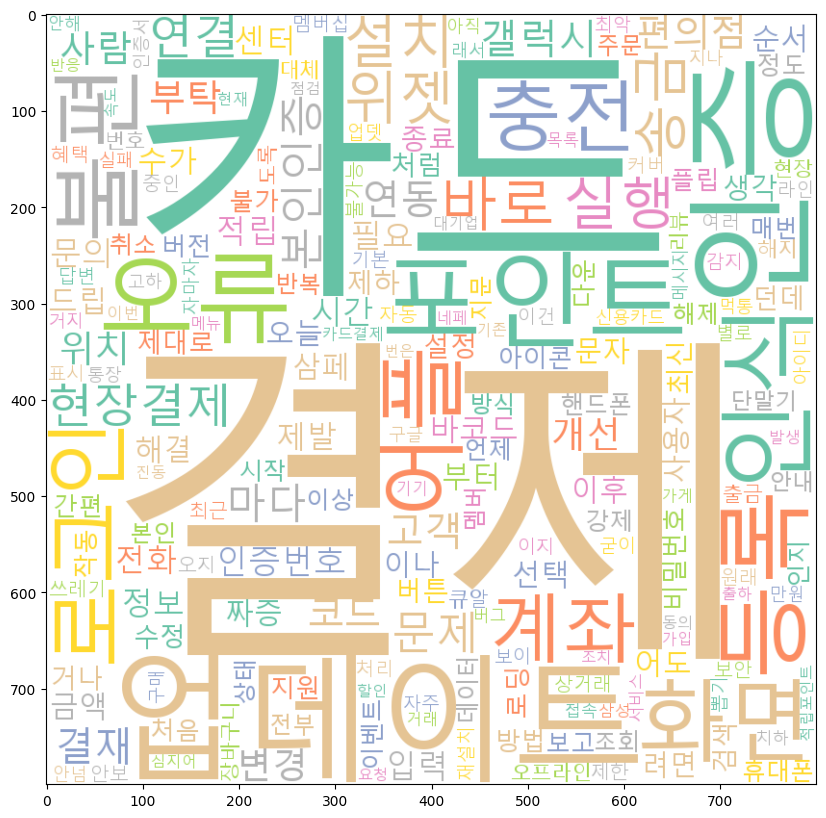

In [76]:
#### 2021년~~2023년

wordcloud=wordcloud.generate_from_frequencies(Counter(cleaned_nouns))
array=wordcloud.to_array()
fig=plt.figure(figsize=(10,10))
plt.imshow(array, interpolation="bilinear")
plt.show()

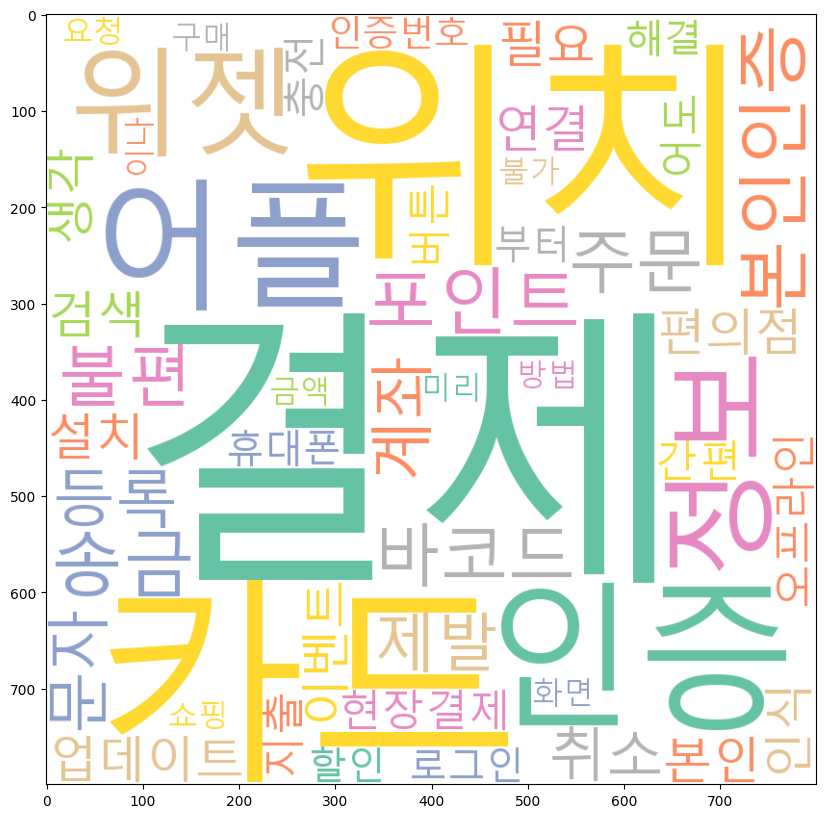

In [77]:
#### 2021년

df_words2021=Counter(y_21)
wordcloud_21=wordcloud.generate_from_frequencies(dict(df_words2021.most_common(50)))
array=wordcloud_21.to_array()
fig=plt.figure(figsize=(10,10))
plt.imshow(array, interpolation="bilinear")
plt.show()

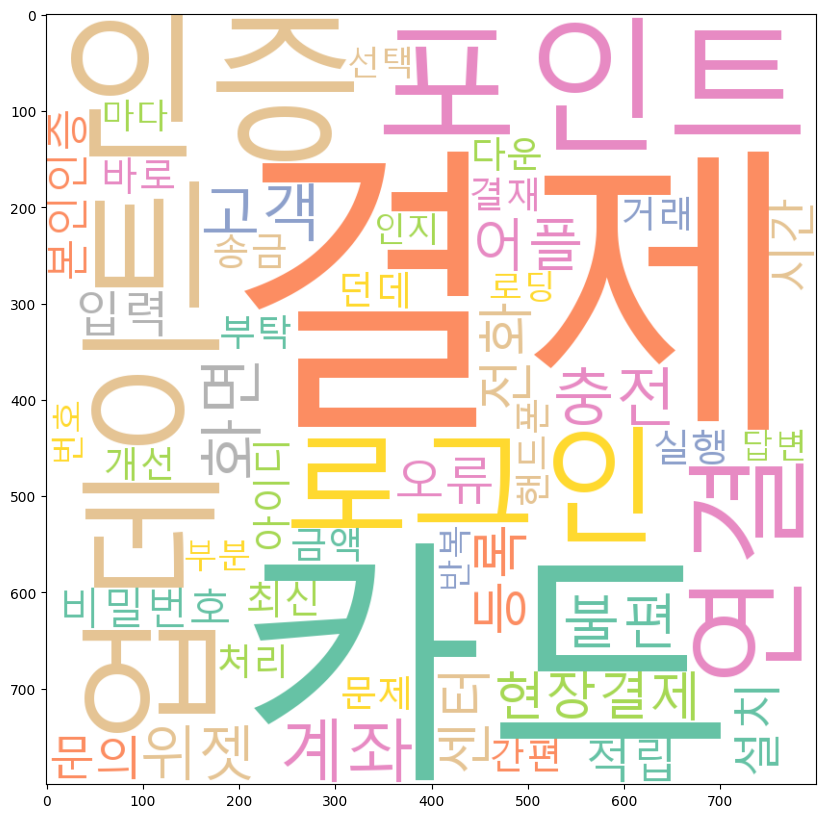

In [86]:
#### 2022년

df_words2022=Counter(y_22)
wordcloud_22=wordcloud.generate_from_frequencies(dict(df_words2022.most_common(50)))
array=wordcloud_22.to_array()
fig=plt.figure(figsize=(10,10))
plt.imshow(array, interpolation="bilinear")
plt.show()

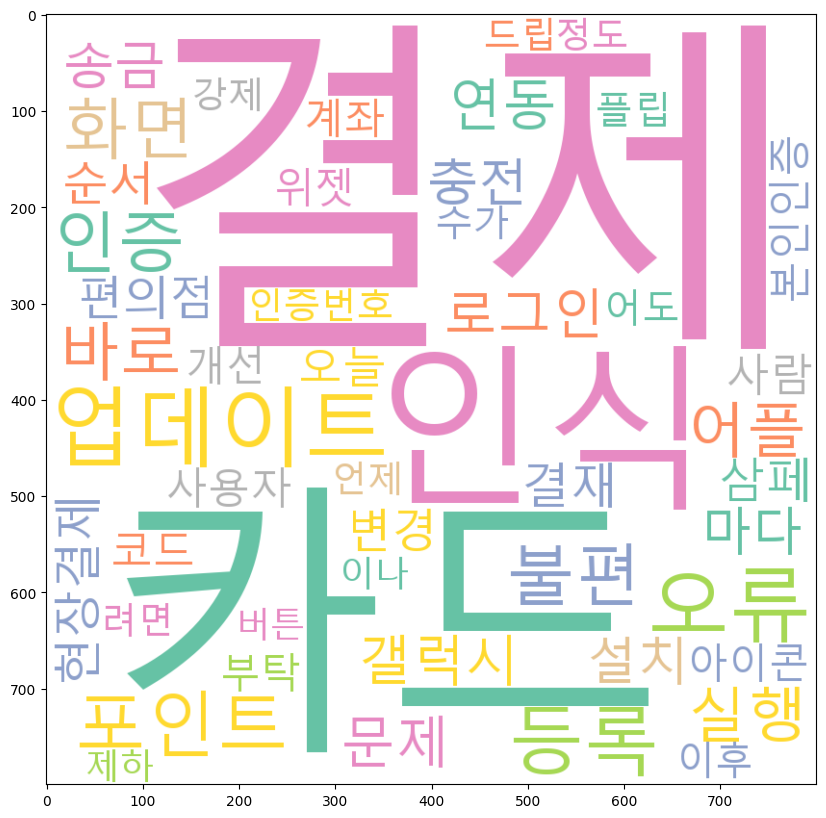

In [79]:
#### 2023년
df_words2023=Counter(y_23)
wordcloud_23=wordcloud.generate_from_frequencies(dict(df_words2023.most_common(50)))
array=wordcloud_23.to_array()
fig=plt.figure(figsize=(10,10))
plt.imshow(array, interpolation="bilinear")
plt.show()

In [80]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '위치' in np.array(data['리뷰2'])[i]:
        print(np.array(data['리뷰1'])[i])

인식이 잘 안되는거 같아요 결제시 잠금해제 뜨기까지도 시간이 좀걸리고 해제하고나서 결제가능상태로 넘어가는데도 시간이 좀걸리는 경우가 종종있어요 어쩔땐 결제가능상태로 빨리 바뀐다해도 결제단말기에 잘인식이 안되서 몇번씩 다시하는 경우가 생기네요 재시도도해보고 핸드폰을 결제단말기에 접촉시키는 위치도 바꿔보고 그러다 결국 그냥 실물카드 이용하거나 삼성페이사용하게 됩니다
현장결제하려는데 위치기능 켜졌고 권한도 있고 토스어플은 내 위치 잘만 잡는데 계속 씨름해도 내 위치 못잡음 위치정보가 없다함 어쩌다 잡히는데 왜 잡히는지 모르겠고 껐다 다시 키면 또 못잡음 성질버리게 만드는 어플이네 위치 권한 들어가면 이 어플은 위치정보 요청하지도 않았다함 네페어플에서 내위치 아무리 버튼 눌러도 미동도 않음 쓰레기
현재 위치정보 갱신이 안되는데 검색기능도 없어서 미리주문을 하고싶어도 할 수가없음 GPS 초기화를 하니 아예 이상한 위치로 고정되서 바뀌지도 않음 네이버라는 대기업에서 만든 앱이라고 생각하기에는 너무나 형편없는것 같습니다
삼성페이 인식 잘 안됩니다 같은 위치에 똑같이 가져다대는데 네이버페이 앱에 있는 삼성페이로는 인식 오류 자주 뜹니다
위치정보 안쓰고 주문좀 하게 해주세요 사용자 위치정보 수집해서 알고리즘 발전시키려는 의도는 알겠는데 제대로 인식도 못해서 주문을 못하게 하면 이용하려다가도 타 앱으로 넘어가고 싶어지잖아요
위치정보오류가 많아요 주문시 당장필요한데 몇시간 지나야 제대로 잡히니 이거뭔 필요할때 주문을 할수가 없네요
주문할때 위치를 못잡음 검색 기능이 없어서 주문 불가
위치를 못잡아요 지방 에서 위치잡는데 계속 광화문임
서비스 너무 엉망 입니다 전 대구 사는데 위치는 서울로 뜨고 바꾸고싶어도 못 바꾸고 계좌 이체는 왜 만원씩 해야하나요 토토 하는것도 아니고
GPS켜도 위치가 서울특별시로 고정되고 잡지를 못하네요 처리좀해주시죠
전 수원 사는데 주문 위치는 서울로 나오고 지도 내려서 현위치 검색하니까 먹통 되고 확실히 몬가 불안정 적이네요


In [81]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '적립' in np.array(data['리뷰2'])[i]:
        print(np.array(data['리뷰1'])[i])

적립포인트와 충전포인트를 왜 구분하는지 이해가 안갑니다 적립은 내가 결제를 해서 쌓은 것이고 충전은 내통장의 돈을 끌어와서 쌓습니다 저는 적립부분은 캐쉬백으로 돌려받고 싶고 충전포인트는 소득공제용으로 씁니다 구매시에는 적립 충전이 상관없는데 인출은 충전포인트만 됩니다 새로운 카드결제보다 포인트로 물건을 사야하는게 정녕 네이비페이의 의도인가요 수익면에서도 이익인가요 이건 제가받은 혜택도 알기어렵고 가계부 입력할때도 추가작업이 필요하고 실제 얼마짜리였는지 자세히 알기도 힘듭니다 요지는 적립포인트도 결제에만 국한하디 말고 인출도하게 해주십시오 네이버플러스멤버쉽을 쓰고있는데 점점 이탈자가 많아질것같습니다 포인트교환 대상처 확대해주시고 적립포인트도 가능하게 해주세요
도대체가 앱이 왜이렇게 먹통이 자주 일어납니까 포인트 이벤트 페이지에서 인증만 했다 하면 바로 새하얀 화면 되고 멈추네요 신규 가입자만 받을 수 있는 포인트인데 이런 식으로 막히면 받을 수도 없고 참 답답 합니다 취소시키면 포인트도 날아가고 동시에 앱도 작동을 안하네요 도대체가 이렇게 불편해서 앞으로 네이버페이 포인트 적립 이벤트에 참여하겠나 싶습니다 어떻게 대안을 좀 찾던가 하세요
포인트내역 불편합니다 사용했으면 당시에 남은 금액이 얼마였는지 확인이 불가합니다 최종 남은 금액만 확인 가능할뿐이네요 충전하고 취소하고 이게 금액이 맞는건지 추후에 확인할 방법이 없습니다 네이버만 믿어야 하나보네요 그리고 구매적립예정 같은 경우엔 내가 구매한 내역 밑에 표시하는게 깔끔하고 보기 편할것 같아요 라인만 늘릴뿐이지 불편합니다 제발 남은 금액표시 좀 해주세요 상단 말구요 하나 하나요 은행앱처럼 페이가 돈이잖아요
요기요 첫주문하고 적립받기 참여했는데 적립이 안되네요 문의하려했더니 참여한 캠페인을 선택해야된대서 목록을 둘러봤는데 요기요는 없네요 적립 안되는 경우 어쩌다 한번 있는데 목록도 제대로 안줘놓고 문의하라고 하는건 무책임한 것 같습니다
예전엔 카페음료 결제시 적립같은 실용적인 이벤트 많았었는데 요즘엔 안해서 아쉬움 

In [82]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '바코드' in np.array(data['리뷰2'])[i]:
        print(np.array(data['리뷰1'])[i])

아니 편의점에서 결재할라고 바코드 찾으니까 없어가지고 캐당황했네 그래도 깔아가지고 써볼랬더만 인증문자는 뭐 국끓여먹었나 왜 오질않아 번이나 시도하다 딴걸로 결재했다 기존에 네이버 앱하나만 있으면 되서 엄청 편하게 쓰고 있었는데 뭘또 깔라는거야 개불편해서 안쓴다 바코드 하나만 앱에서 띄워서쓰면 되서쓰는게 이유였는데 그걸 없애네
며칠전 이달의 행사가 업데이트된 이후 네이버페이 화면이 제대로 표시되지 않아 바코드 부분이 잘려나옵니다 댓글보면 저와 같은 분들 있으시던데 구글 스토어 네이버페이 열기 로 하면 또 제대로 나옵니다
페이코 삼페쓰다가 네이버삼페쓰니까 진 짜 불편하네요 UI UX가 이래서 중요한가봅니다 결제카드고르는거나 결제전 지문인식하기까지의 터치 뎁스나 결제와 동시에 멤버십 바코드 띄우는거나 기타등등 한화면에 꾸겨넣으려다보니 이지경이 된거 같은데 네이버라는 대기업답지않게 너무 불편 UX입니다 제 리뷰 읽으실필요없고 그냥 페이코 삼성페이 써보세요 심플 그 잡채입니다 게다가 MST만 되고 NFC 결제 안되는거 불편하네요 계속느끼는 거지만 결제시 멤버십 바코드 못띄우는거 오지게 불편
파리바게트 가려고 깔았는데 네이버페이는 되는데 큐알결제안된다고 바코드를 달래요 어플이나 네이버 앱 뒤지다 결국 못찾아서 못하고 카드계산하고 바로 지웠네요 아직 잘 되지는 않나봐요
네이버페이를 삼성페이처럼 사용해보고 싶어서 설치했으나 바코드 결제가 다여서 삭제함 오프라인에서 사용하기에는 무리가 있는 것 같음
네이버 페이로 현장결제 할려고 네이버현대카드 선택하면 카드를 찾을 수 없다고 나오는데 어떻게 사용하나요 그리고 기본 네이버페이 바코드 찍으면 알아서 연결된 카드로 결제되는건가요
왜 간편결제 바코드가 안찍히나요 천원이벤트해서 쓸려는데 안찍혀요 다른 네모 바코드는 다 잘 찍히던데
네이버페이결제방식중에 바코드형식으로도할수있게 기능을넣어주세요 어떤매장은이거때문에 결제도할수없고너무불편해요 바코드결제형식도넣어주세요 부탁드려요
다이소에서 현장결제시 바코드 생성이 잘 안 됩니다
편의점결제 전에 

In [83]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '설치' in np.array(data['리뷰2'])[i]:
        print(np.array(data['리뷰1'])[i])

월 일날짜로 유니온페이 해외결제버전 나왔다고 해서 설치해보려 했지만 월 일 라인페이 제휴종료버전만 설치됨 아이콘만 바뀐 가짜업데이트버전임
갤럭시 워치 에서 아예 네이버페이 어플 검색이 안되는데 왜 그럴까요 다른 분들은 워치에 잘만 어플 설치해서 쓰시던데 제 워치에서는 검색이 안되네요
얼마 전까지만 해도 PC에서 네이버머니 인출할 수 있었는데 이젠 중국마냥 앱 강제로 설치해서 인출해야 하네요 짧은 순간에 회를 연달아서 인증하는데 번째는 심지어 나이 드신 분들 인출하기 어렵도록 인증번호를 소리로 전달하는 것에서 악의를 느꼈습니다
워치에서 간편결제 지원하다고해서 설치했는데 기획자가 신입인듯 하다 네이버 포인트로만 결제되게한건 사업적이나 기술적 제한이 있었다고 이해할수 있다 용서가 안되는건 결제를 간편하게하려고 굳이 워치앱을 설치하는건데 그 조그마한 화면에서 결제비밀번호를 입력해야되게 해놨다 비밀번호입력시 계속 오타나고 짜증나서 그냥 폰으로하고말지 왜 워치를 써야하나 모르겠다 간편결제면 간편결제답게 간편하게 만들어라 티머니가 모범답안이다
왜 존재하는지 모르겠는 어플 입니다 오직 네이버페이기능만필요해서 설치했더니 다른 앱에서 결제시 네이버페이를 쓸려고 하면 웹사이트를 이용하던가 무조건 네이버어플을 필요로합니다 심지어 네이버페이에서 일부기능들도 네이버어플을 요구합니다 이럴꺼면 왜 따로 만든건지 이해가 안가는군요
평가 같은거 안하는데 네이버이건 악플달고 싶을정도임 기존에 웹이나 앱설치없이 간단히 송금돼던걸 앱설치 안하면 못하게만든거 이건정말 최악 충전은 없어도 잘돼게 해놓고 이게 뭔짓거린지
편의점 충전하기 할려고 하니까 이 어플 설치하라고 뜨네요 없애주세요 페에앱 없이도 편의점 충쟌하기 가능하게 해주세요 이 앱 너무 불편합니다 요즘에 너무 자주 바꿔서 익숙하지도 않고요
안되는 단말기가 많은건가요 처음 몇번 되더니 되던 곳도 안되네요 다시 설치 해야되나요
잘 쓰고있었는데 업데이트 후에 악성 어플리케이션이 감지되었다며 꺼집니다 어떤 어플인지 알려주지도 않고 새로 설치한 어플도

In [84]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '화면' in np.array(data['리뷰2'])[i]:
        print(np.array(data['리뷰1'])[i])

이 앱 편의점이나 커피체인점에서 쓸때마다 화나는게 현장결제 때문에 클릭하면 맨날 본인인증 다시하라고 초기화면 떠있음 몇원 더받으려고 쓰는건데 인증도 한두번이지 뒤에 다른손님 서있는데 몇분 본인인증하다 허비하고 쪽팔리는게 한두번이 아님 장난치는것도 아니고 매번 본인인증하라고 인증 풀려져 있어서 성질나서 네이버페이앱 절대 안쓰고 네이버 앱만 쓰게됨
잘 사용하고 있었는데 삼성페이 화면에서 카드 선택이 안 떠요 원래 카드 목록이 보이고 눌러서 카드 선택 후 결제해서 그때그때 골라 결제했는데 위젯아이콘 누르면 자꾸 연결되지 않았다고 뜨고 접속돼도 카드가 안 뜨니 무슨 카드 인지도 모르고 결제가 잘못될까 봐 결제하기가 좀 그래요
이번 패치 이후에 플립 플렉스윈도우 커버화면 호환이 안돼요 GOOD LUCK 앱으로 네이버페에 QR코드 잘 사용해서 결제했는데 이번 업데이트 이후로는 QR코드만 가려져서 삼성페이도 안돼고 폰를 열어야지 가능해졌습니다 원래 잘 사용되었다가 업데이트 이후로 안돼서 답답하네요
Z플립 커버화면에서는 바로결제 기능을 사용하지 않으면 결제 할 수가 없어 불편합니다 바로결제 기능 안쓰는 사용자도 커버화면에서 결제 가능했음 좋겠어요
갤럭시 플립 입니다 외부 화면에 QR코드가 안나와요 결제 할때마다 항상 열어서 결제 해야 하는데 불편함이 있습니다 업그레이드 전에는 사용가능 했는대 왜 업그레이드 되면서 안되나요 답변부탁드립니다
플립 커버화면에서 측면버튼 두번 눌러서 바로 실행하면 화면을 열라고 뜨네요 이전에 열지않고 바로 사용 가능했는데
페이 실행 후 결제를 하지 않고 덮개를 덮었다가 다시 화면을 열면 아무런 동작을 하지 않네요 생체인식을 강제로 시켜줘야 홈버튼이 먹혀서 기본화면으로 돌아가는 버그가 있네요
업데이트이후 페이를 쓰기 힘듬 분간 진동울리며는 화면이 멈춰있음 해결안되면 네이버 해지해야겠음 페이쓰려면 인내가 필요하고 뒤에서 사람 기대려서 눈치보이고 짜증남
이번 업데이트후에 플립 커버화면엔 결제가능 시간이 안보입니다 또 아이콘이 타 아이콘에 비해 엄청 작네

In [85]:
data3=pd.DataFrame()

for i in list(range(len(data))):
    if '번호' in np.array(data['리뷰2'])[i]:
        print(np.array(data['리뷰1'])[i])

지금 세 번 사용했는데 한 번은 카드 번호가 다르다며 결제 거부 당하고 한 번은 성공하고 한 번은 걍 인식이 안 돼서 결국 삼성페이로 결제를 했습니다 같은 카드를 썼는데 한 번 성공한거 보면 카드 문제는 아닌 것 같고 분 전에 결제 되던게 다른 가게에선 인식이 아애 안 됐는데 삼페로 하니 결제가 되는걸 보면 걍 앱 문제 같은데 얼른 해결 좀 해주셨으면 좋겠네요 계속 이러면 혜택이 좋아도 짜증나서 안 쓰게 될 것 같네요
알뜰폰 사용자입니다 모두 입력후 인증 누르면 반응이 없어요 번호가 안떠요 인증번호 보냈다고 메시지는 떴어요 몇달전 앱깔고 시도했는데 안되서 앱삭제 오늘 다시시도 지난번이랑 똑같아서 앱사용 불가능상태입니다
생각좀 해봐요 갤럭시랑 아이폰 이렇게 폰 두대쓰는 사람은 매번 인증을 받나요 예전에는 두폰에서 잘되었는데 짜증나요 인증번호받은걸로 번호변경까지 되던데 그러지마요 아 추가로 카드 순서도 사용자가 순서를 정해서 나열시키고 싶어도 그런것도 지원안해주고 불편해요
네이버페이앱 인증관련 오류인지 인증버튼 눌러도 문자가 안오네요 수신차단번호에도 없는것 같은데 네이버앱으로는 사용가능한듯한데
잘 쓰다가 갑자기 본인인증이 안돼서 못 써요 내 이름 생년월일 번호 다 맞는데 인증번호가 안 오네요 스팸 해둔 것도 아닌데
본인 명의 휴대폰 통해서 인증가능이라고계속뜨네요 번시도했는데 안되네 내휴대번호 맞는데 왜이러죠
인증번호 회시도 했는데 회 할때마다 분 이상 걸리고 인증번호 눌러도 번호확인하라는 오류메세지 뜹니다 해결해주세요
비밀번호 번틀린다음 번호 알아오니까 번 틀렸다고 재시도가 안돼요
거지같은 본인인증 도대체 달 마다 번호 인증 하는 이유가 머임 공인인증서 사용도 안되고 지문도 안되고 안쓴다 퉤
인정 번호두 안오면 어떡해 가입하나요
